In [10]:
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
import arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pykalman import KalmanFilter
import statistics
import csv

In [2]:
# !pip install pykalman

In [2]:
# Load the dataset into a Pandas DataFrame
df = pd.read_csv('FR_next.csv')
df

,Date,Prices,Generation forecast,System load forecast
0,2017-01-01 00:00:00,58.82,70810.0,75500.0
1,2017-01-01 01:00:00,58.23,69539.0,73650.0
2,2017-01-01 02:00:00,51.95,67376.0,72350.0
3,2017-01-01 03:00:00,47.27,65412.0,68750.0
4,2017-01-01 04:00:00,45.49,64557.0,65900.0
...,...,...,...,...
52580,2022-12-31 20:00:00,7.60,44648.0,46950.0
52581,2022-12-31 21:00:00,3.69,43841.0,44350.0
52582,2022-12-31 22:00:00,1.88,44578.0,43950.0
52583,2022-12-31 23:00:00,0.10,45135.0,47250.0


In [3]:
dfb = df

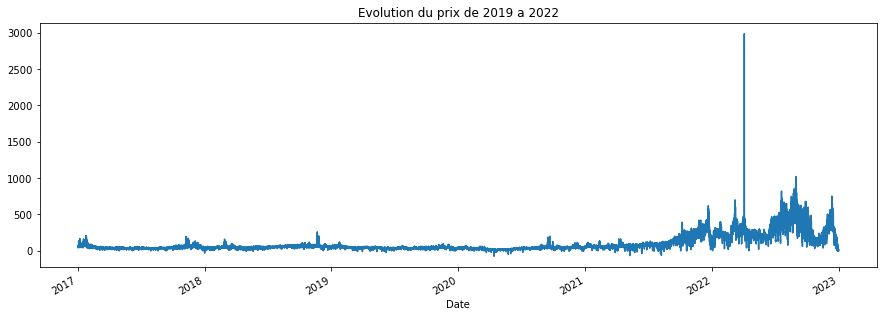

In [4]:
df_date = df

# Convertir la colonne Date en datetime
df_date['Date'] = pd.to_datetime(df_date['Date'])

# Définir la colonne Date comme index du dataframe
df_date.set_index('Date', inplace=True)

# Définir la taille de la figure
plt.figure(figsize=(15, 5))

# Tracer les données en utilisant la méthode plot() de pandas
df_date[' Prices'].plot()

# Ajouter un titre au graphique
plt.title('Evolution du prix de 2019 a 2022')

# Afficher le graphique
plt.show()

In [5]:
dfb = dfb.reset_index()

In [7]:
# Convertir la colonne Date en format datetime
dfb['Date'] = pd.to_datetime(dfb['Date'])

# Définir les bornes de la plage de dates souhaitée
start_date_train = '2017-01-01 00:00:00'
end_date_train = '2020-12-31 23:00:00'

start_date_test = '2021-01-01 00:00:00'
end_date_test = '2022-12-31 23:00:00'

# Sélectionner les lignes entre les bornes de dates
train_data = dfb.loc[(dfb['Date'] >= start_date_train) & (dfb['Date'] <= end_date_train)]

test_data = dfb.loc[(dfb['Date'] >= start_date_test) & (dfb['Date'] <= end_date_test)]

In [8]:
train_data

,Date,Prices,Generation forecast,System load forecast
0,2017-01-01 00:00:00,58.82,70810.0,75500.0
1,2017-01-01 01:00:00,58.23,69539.0,73650.0
2,2017-01-01 02:00:00,51.95,67376.0,72350.0
3,2017-01-01 03:00:00,47.27,65412.0,68750.0
4,2017-01-01 04:00:00,45.49,64557.0,65900.0
...,...,...,...,...
35059,2020-12-31 19:00:00,60.54,70648.0,70850.0
35060,2020-12-31 20:00:00,56.75,69866.0,67800.0
35061,2020-12-31 21:00:00,52.44,68126.0,64900.0
35062,2020-12-31 22:00:00,51.86,67610.0,64800.0


In [9]:

# replace missing values with the mean value of the column
test_data[' Generation forecast'].fillna(test_data[' Generation forecast'].mean(), inplace=True)
display(test_data)

# replace missing values with the mean value of the column
train_data[' Generation forecast'].fillna(train_data[' Generation forecast'].mean(), inplace=True)
display(train_data)

C:\Users\sokhn\AppData\Local\Temp\ipykernel_14596\3222748322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[' Generation forecast'].fillna(test_data[' Generation forecast'].mean(), inplace=True)


,Date,Prices,Generation forecast,System load forecast
35064,2021-01-01 00:00:00,50.87,63690.0,66500.0
35065,2021-01-01 01:00:00,48.19,62414.0,64600.0
35066,2021-01-01 02:00:00,44.68,60612.0,63700.0
35067,2021-01-01 03:00:00,42.92,58978.0,60600.0
35068,2021-01-01 04:00:00,40.39,58520.0,58150.0
...,...,...,...,...
52579,2022-12-31 19:00:00,18.11,45503.0,49650.0
52580,2022-12-31 20:00:00,7.60,44648.0,46950.0
52581,2022-12-31 21:00:00,3.69,43841.0,44350.0
52582,2022-12-31 22:00:00,1.88,44578.0,43950.0


C:\Users\sokhn\AppData\Local\Temp\ipykernel_14596\3222748322.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[' Generation forecast'].fillna(train_data[' Generation forecast'].mean(), inplace=True)


,Date,Prices,Generation forecast,System load forecast
0,2017-01-01 00:00:00,58.82,70810.0,75500.0
1,2017-01-01 01:00:00,58.23,69539.0,73650.0
2,2017-01-01 02:00:00,51.95,67376.0,72350.0
3,2017-01-01 03:00:00,47.27,65412.0,68750.0
4,2017-01-01 04:00:00,45.49,64557.0,65900.0
...,...,...,...,...
35059,2020-12-31 19:00:00,60.54,70648.0,70850.0
35060,2020-12-31 20:00:00,56.75,69866.0,67800.0
35061,2020-12-31 21:00:00,52.44,68126.0,64900.0
35062,2020-12-31 22:00:00,51.86,67610.0,64800.0


In [ ]:
# Set the length of the training set
train_len = len(train_data)
#print(train_len)

# Create an empty array to store the predictions
predictions = []

# Iterate over each point in the test set
for i in range(0, len(test_data), 24):
    # Select the data for training the model
    if i == 0:
        train_data_subset = train_data.iloc[:train_len, :]
    else:
        train_data_subset = pd.concat([train_data.iloc[i:, :], test_data.iloc[:i, :]], axis=0)
    #print("train data :", train_data_subset)
        
    # Fit the ARIMA model to the training data
    model = ARIMA(train_data_subset.iloc[:, 1], exog=train_data_subset.iloc[:, 2:], order=(1,1,1))
    result = model.fit()
    
    # Make one-day-ahead forecasts
    forecast = result.forecast(steps=24, exog=test_data.iloc[i:i+24, 2:])
    print("prédictions :", forecast)
    
    # Store the forecasts in the predictions array
    predictions.extend(forecast)
    


In [11]:
print(len(predictions))

17520


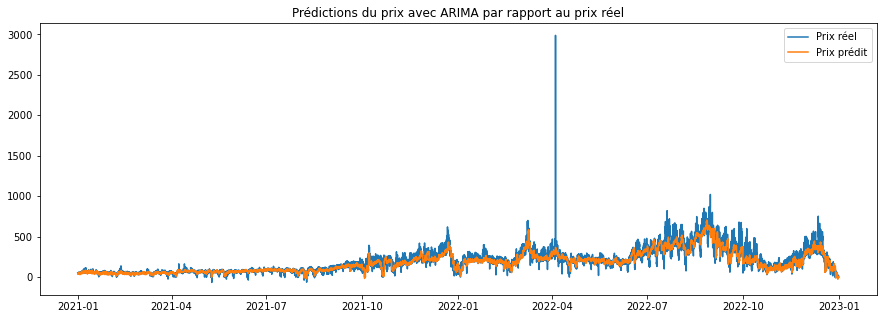

In [12]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
plt.plot(test_data['Date'], predictions, label='Prix prédit')
plt.legend()
plt.title('Prédictions du prix avec ARIMA par rapport au prix réel')
plt.show()

In [13]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list = []
for i in range(len(predictions)):
    mae = mean_absolute_error([test_data.iloc[i, 1]], [predictions[i]])
    mae_list.append(mae)
    
# Imprimer la liste des MAE
#print("Liste des MAE :", mae_list)


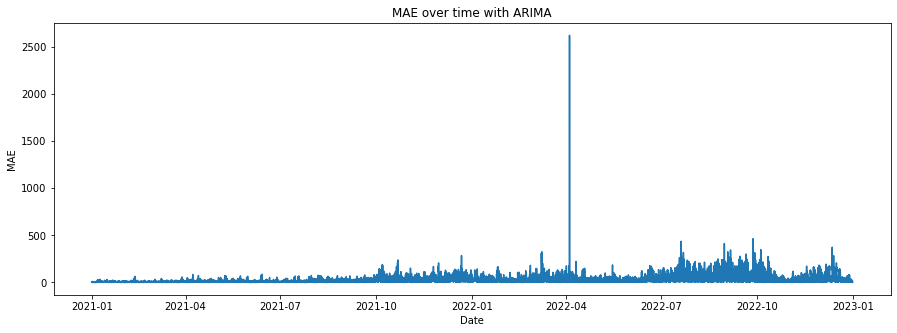

In [14]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], mae_list)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('MAE over time with ARIMA')
plt.show()

Le modèle ARIMA-GARCH est souvent utilisé pour modéliser la série temporelle des prix de l'électricité. Les modèles ARIMA sont généralement utilisés pour modéliser les tendances, les saisons et les cycles d'une série temporelle. Cependant, les modèles ARIMA ne prennent pas en compte l'hétéroscédasticité, qui est fréquente dans les séries temporelles de prix de l'électricité, c'est-à-dire la variance variable des erreurs.

D'un autre côté, les modèles GARCH sont utilisés pour modéliser l'hétéroscédasticité conditionnelle, c'est-à-dire la variance variable des erreurs qui dépend de la valeur des erreurs précédentes. Les modèles GARCH peuvent être utilisés pour estimer la volatilité de la série temporelle, ce qui peut être utile pour la prise de décisions en matière de négociation et de gestion des risques.

En combinant les deux modèles, ARIMA et GARCH, on peut obtenir des prévisions plus précises et fiables des prix de l'électricité. Le modèle ARIMA peut être utilisé pour modéliser les tendances et les saisons, tandis que le modèle GARCH peut être utilisé pour modéliser l'hétéroscédasticité conditionnelle et estimer la volatilité future de la série temporelle. Cette combinaison permet de mieux capturer les caractéristiques complexes et dynamiques des prix de l'électricité et d'améliorer la précision des prévisions.

In [ ]:
# Create an empty array to store the residuals
residuals = []


# Iterate over each point in the test set
for i in range(len(predictions)):
    # Calculate the residuals
    residuals.append(test_data.iloc[i, 1] - predictions[i])

# Fit a GARCH model to the residuals with the ARIMA forecasts as exogenous variables
am = arch_model(residuals, x=predictions, vol='GARCH', p=1, q=1)
res = am.fit()

# Make one-day-ahead forecasts using the GARCH model
garch_forecasts = []
for i in range(0, len(test_data), 24):
    forecast = res.forecast(horizon=24)
    garch_forecasts.extend(forecast.variance.values[-1, :])

print("GARCH forecasts :", garch_forecasts)

Le modèle GARCH peut être utilisé pour estimer la volatilité des résidus de votre modèle ARIMA, ce qui peut aider à mieux comprendre et à améliorer la précision de vos prévisions du prix de l'électricité. En effet, en utilisant les prévisions GARCH pour estimer la volatilité future de l'électricité, vous pouvez prendre en compte les fluctuations imprévisibles de la volatilité et mieux évaluer la fiabilité de vos prévisions de prix.

Par exemple, si le modèle GARCH prévoit une forte augmentation de la volatilité dans un proche avenir, cela peut indiquer une incertitude accrue sur les prévisions de prix de l'électricité, ce qui peut aider à ajuster les attentes et les décisions d'investissement.

En outre, l'utilisation de modèles de volatilité tels que GARCH peut aider à améliorer les performances des modèles de prévision des prix en ajustant les prévisions pour les effets de volatilité, qui peuvent avoir un impact significatif sur les prix de l'électricité.

En résumé, l'utilisation du modèle GARCH peut aider à mieux comprendre et à améliorer la précision de vos prévisions de prix de l'électricité en prenant en compte les fluctuations imprévisibles de la volatilité.

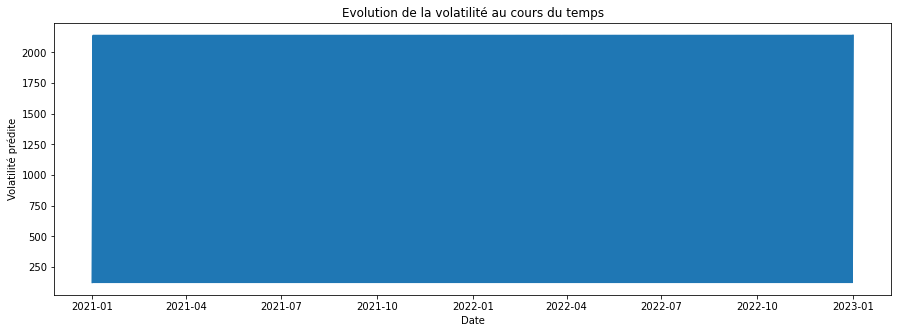

In [16]:
# Plot the volatility over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], garch_forecasts)
plt.xlabel('Date')
plt.ylabel('Volatilité prédite')
plt.title('Evolution de la volatilité au cours du temps')
plt.show()

### Ajustement des prévisions en fonction des effets de volatilité 

Les prévisions ajustées en fonction des effets de volatilité peuvent être obtenues à partir du modèle GARCH. Les prévisions de volatilité du GARCH peuvent être utilisées pour ajuster les prévisions de l'ARIMA en fonction des fluctuations de la volatilité.

En général, on peut ajuster les prévisions de l'ARIMA en multipliant les prévisions par la racine carrée de la volatilité pronostiquée par le modèle GARCH. Cela revient à diviser les prévisions de l'ARIMA par l'écart-type de la série temporelle résiduelle, ce qui normalise les prévisions en fonction des fluctuations de la volatilité.

In [17]:
observations = np.array(garch_forecasts)
# Créer le filtre de Kalman
kf = KalmanFilter(transition_matrices=[1], observation_matrices=[1], initial_state_mean=observations[0], initial_state_covariance=1, observation_covariance=1, transition_covariance=0.01)
# Appliquer le filtre de Kalman aux prédictions de volatilité
filtered_state_means, filtered_state_covariances = kf.filter(observations)
# Récupérer les prédictions de volatilité filtrées
filtered_volatility_predictions = filtered_state_means.flatten()

In [18]:
print(filtered_volatility_predictions)

[ 124.42451331  153.99861516  191.55388814 ... 1386.62728992 1449.80337994
 1515.29891281]


In [19]:
# Adjust the ARIMA forecasts for volatility using the GARCH forecasts
adjusted_forecasts = []
for i in range(len(filtered_volatility_predictions)):
    adjusted_forecasts.append(predictions[i] * np.sqrt(filtered_volatility_predictions[i]) * 0.05) #to adjust the scaling factor, decrease of the scaling factor by a factor of 0.05

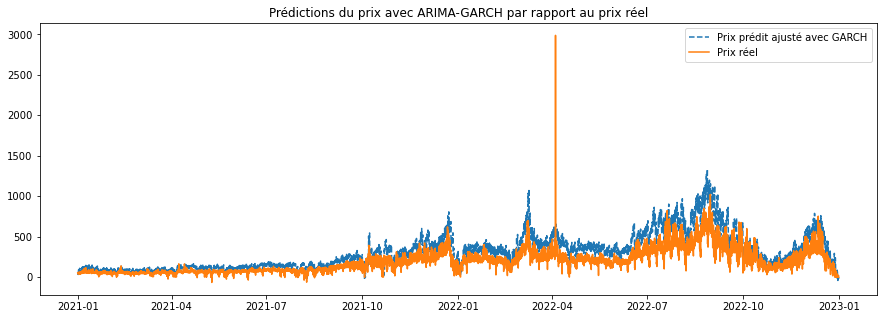

In [20]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data['Date'], adjusted_forecasts, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel")
plt.show()

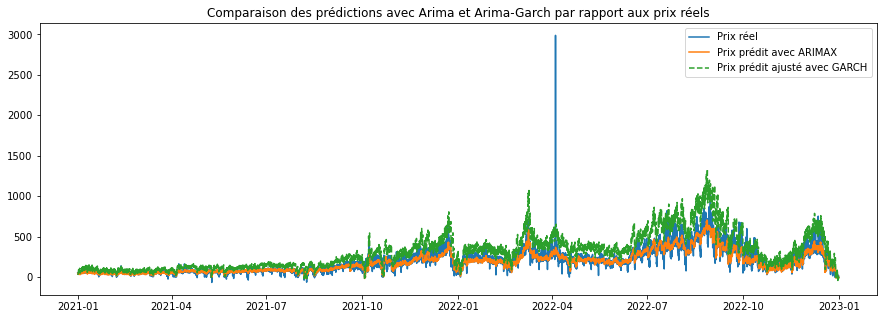

In [21]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data['Date'], adjusted_forecasts, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.legend()
plt.title("Comparaison des prédictions avec Arima et Arima-Garch par rapport aux prix réels")
plt.show()

In [22]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list2 = []
for i in range(len(adjusted_forecasts)):
    mae = mean_absolute_error([test_data.iloc[i, 1]], [adjusted_forecasts[i]])
    mae_list2.append(mae)

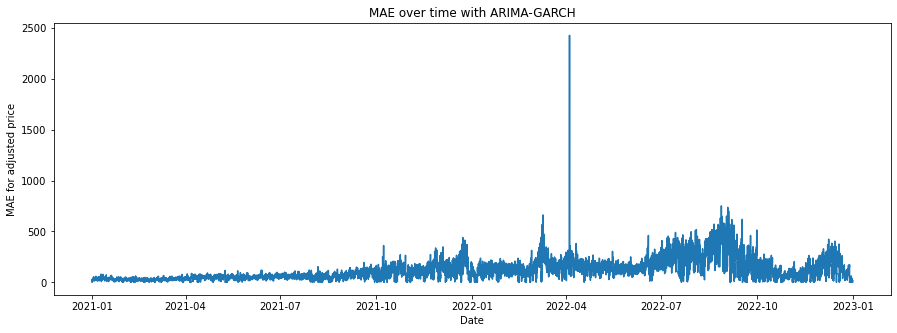

In [23]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data['Date'], mae_list2)
plt.xlabel('Date')
plt.ylabel('MAE for adjusted price')
plt.title('MAE over time with ARIMA-GARCH')
plt.show()

In [ ]:
----------------------- start

## Etude de 2019 à 2022 (comparaison entre les données entsoe et les données fournisseurs)

### Données ENTSOE

In [6]:
# Définir les bornes de la plage de dates souhaitée
start_date_train2 = '2018-12-31 00:00:00' 
end_date_train2 = '2020-12-31 23:00:00'

start_date_test2 = '2021-01-01 00:00:00'
end_date_test2 = '2022-06-30 23:00:00'


# Sélectionner les lignes entre les bornes de dates
train_data2 = dfb.loc[(dfb['Date'] >= start_date_train2) & (dfb['Date'] <= end_date_train2)]

test_data2 = dfb.loc[(dfb['Date'] >= start_date_test2) & (dfb['Date'] <= end_date_test2)]

In [7]:
train_data2.reset_index(drop=True)

,Date,Prices,Generation forecast,System load forecast
0,2018-12-31 00:00:00,50.94,67247.0,62950.0
1,2018-12-31 01:00:00,49.57,65041.0,59900.0
2,2018-12-31 02:00:00,48.32,64608.0,59000.0
3,2018-12-31 03:00:00,45.89,63406.0,56050.0
4,2018-12-31 04:00:00,45.47,63325.0,54100.0
...,...,...,...,...
17563,2020-12-31 19:00:00,60.54,70648.0,70850.0
17564,2020-12-31 20:00:00,56.75,69866.0,67800.0
17565,2020-12-31 21:00:00,52.44,68126.0,64900.0
17566,2020-12-31 22:00:00,51.86,67610.0,64800.0


In [8]:
test_data2.reset_index(drop=True)

,Date,Prices,Generation forecast,System load forecast
0,2021-01-01 00:00:00,50.87,63690.0,66500.0
1,2021-01-01 01:00:00,48.19,62414.0,64600.0
2,2021-01-01 02:00:00,44.68,60612.0,63700.0
3,2021-01-01 03:00:00,42.92,58978.0,60600.0
4,2021-01-01 04:00:00,40.39,58520.0,58150.0
...,...,...,...,...
13098,2022-06-30 19:00:00,479.00,45017.0,49050.0
13099,2022-06-30 20:00:00,450.00,43164.0,46600.0
13100,2022-06-30 21:00:00,394.21,41334.0,44200.0
13101,2022-06-30 22:00:00,367.95,40844.0,44600.0


In [9]:
# replace missing values with the mean value of the column
test_data2[' Generation forecast'].fillna(test_data2[' Generation forecast'].mean(), inplace=True)
display(test_data2)

# replace missing values with the mean value of the column
train_data2[' Generation forecast'].fillna(train_data2[' Generation forecast'].mean(), inplace=True)
display(train_data2)

C:\Users\sokhn\AppData\Local\Temp\ipykernel_2524\2532132216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data2[' Generation forecast'].fillna(test_data2[' Generation forecast'].mean(), inplace=True)


,Date,Prices,Generation forecast,System load forecast
35064,2021-01-01 00:00:00,50.87,63690.0,66500.0
35065,2021-01-01 01:00:00,48.19,62414.0,64600.0
35066,2021-01-01 02:00:00,44.68,60612.0,63700.0
35067,2021-01-01 03:00:00,42.92,58978.0,60600.0
35068,2021-01-01 04:00:00,40.39,58520.0,58150.0
...,...,...,...,...
48162,2022-06-30 19:00:00,479.00,45017.0,49050.0
48163,2022-06-30 20:00:00,450.00,43164.0,46600.0
48164,2022-06-30 21:00:00,394.21,41334.0,44200.0
48165,2022-06-30 22:00:00,367.95,40844.0,44600.0


C:\Users\sokhn\AppData\Local\Temp\ipykernel_2524\2532132216.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data2[' Generation forecast'].fillna(train_data2[' Generation forecast'].mean(), inplace=True)


,Date,Prices,Generation forecast,System load forecast
17496,2018-12-31 00:00:00,50.94,67247.0,62950.0
17497,2018-12-31 01:00:00,49.57,65041.0,59900.0
17498,2018-12-31 02:00:00,48.32,64608.0,59000.0
17499,2018-12-31 03:00:00,45.89,63406.0,56050.0
17500,2018-12-31 04:00:00,45.47,63325.0,54100.0
...,...,...,...,...
35059,2020-12-31 19:00:00,60.54,70648.0,70850.0
35060,2020-12-31 20:00:00,56.75,69866.0,67800.0
35061,2020-12-31 21:00:00,52.44,68126.0,64900.0
35062,2020-12-31 22:00:00,51.86,67610.0,64800.0


In [ ]:
# Set the length of the training set
train_len2 = len(train_data2)
#print(train_len)

# Create an empty array to store the predictions
predictions2 = []

# Iterate over each point in the test set
for i in range(0, len(test_data2), 24):
    # Select the data for training the model
    if i == 0:
        train_data_subset2 = train_data2.iloc[:train_len2, :]
    else:
        train_data_subset2 = pd.concat([train_data2.iloc[i:, :], test_data2.iloc[:i, :]], axis=0)
    #print("train data2 :", train_data_subset2)
        
    # Fit the ARIMA model to the training data
    model2 = ARIMA(train_data_subset2.iloc[:, 1], exog=train_data_subset2.iloc[:, 2:], order=(1,1,1))
    result2 = model2.fit()
    
    # Make one-day-ahead forecasts
    #forecast2 = result2.forecast(steps=24, exog=test_data2.iloc[i:i+24, 2:])
    end_index = min(i + 24, len(test_data2))
    forecast2 = result2.forecast(steps=end_index - i, exog=test_data2.iloc[i:end_index, 2:])

    print("prédictions2 :", forecast2)
    
    # Store the forecasts in the predictions array
    predictions2.extend(forecast2)
    

# Create a CSV file to store the predictions
with open('predictions_ARIMAX.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the predictions to the CSV file
    for prediction in predictions2:
        writer.writerow([prediction])

# Print a message indicating that the predictions have been saved
print("Predictions saved to predictions_ARIMAX.csv")
    



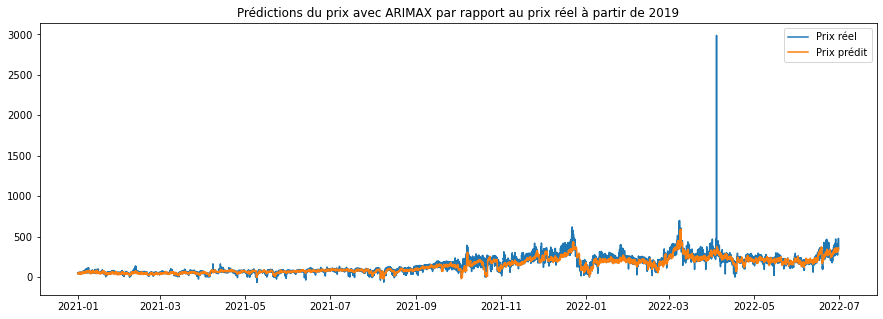

In [15]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data2['Date'], test_data2.iloc[:, 1], label='Prix réel')
plt.plot(test_data2['Date'], predictions2, label='Prix prédit')
plt.legend()
plt.title('Prédictions du prix avec ARIMAX par rapport au prix réel à partir de 2019')
plt.show()

In [16]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list3 = []
for i in range(len(predictions2)):
    mae3 = mean_absolute_error([test_data2.iloc[i, 1]], [predictions2[i]])
    mae_list3.append(mae3)
    
# Imprimer la liste des MAE
#print("Liste des MAE :", mae_list)


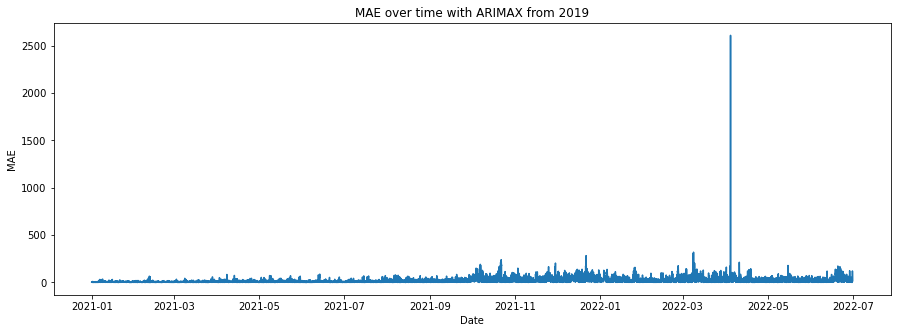

In [17]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data2['Date'], mae_list3)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('MAE over time with ARIMAX from 2019')
plt.show()

In [ ]:
# Create an empty array to store the residuals
residuals2 = []


# Iterate over each point in the test set
for i in range(len(predictions2)):
    # Calculate the residuals
    residuals2.append(test_data2.iloc[i, 1] - predictions2[i])

# Fit a GARCH model to the residuals with the ARIMA forecasts as exogenous variables
am2 = arch_model(residuals2, x=predictions2, vol='GARCH', p=1, q=1)
res2 = am2.fit()

# Make one-day-ahead forecasts using the GARCH model
garch_forecasts2 = []
for i in range(0, len(test_data2), 24):
    forecast2 = res2.forecast(horizon=24)
    garch_forecasts2.extend(forecast2.variance.values[-1, :])

print("GARCH forecasts2 :", garch_forecasts2)

In [19]:
observations2 = np.array(garch_forecasts2)
# Créer le filtre de Kalman
kf2 = KalmanFilter(transition_matrices=[1], observation_matrices=[1], initial_state_mean=observations2[0], initial_state_covariance=1, observation_covariance=1, transition_covariance=0.01)
# Appliquer le filtre de Kalman aux prédictions de volatilité
filtered_state_means2, filtered_state_covariances2 = kf2.filter(observations2)
# Récupérer les prédictions de volatilité filtrées
filtered_volatility_predictions2 = filtered_state_means2.flatten()

print(filtered_volatility_predictions2)

[ 458.63668241  481.89340241  511.42644958 ... 1451.23084661 1500.91305631
 1552.41936601]


In [21]:
# Adjust the ARIMA forecasts for volatility using the GARCH forecasts
adjusted_forecasts2 = []
min_length = min(len(filtered_volatility_predictions2), len(predictions2))
for i in range(min_length):
    adjusted_forecasts2.append(predictions2[i] * np.sqrt(filtered_volatility_predictions2[i]) * 0.04)  # Adjust the scaling factor as needed

# Create a CSV file to store the predictions
with open('predictions_ARIMAX-GARCH.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the predictions to the CSV file
    for prediction in adjusted_forecasts2:
        writer.writerow([prediction])

# Print a message indicating that the predictions have been saved
print("Predictions saved to predictions_ARIMAX-GARCH.csv")

Predictions saved to predictions_ARIMAX-GARCH.csv


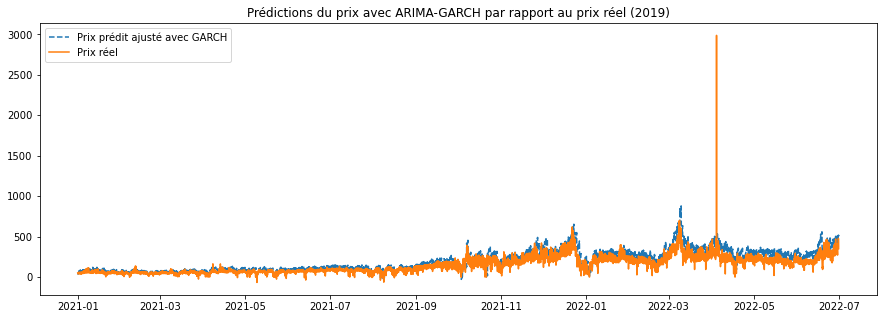

In [22]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data2['Date'], adjusted_forecasts2, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.plot(test_data2['Date'], test_data2.iloc[:, 1], label='Prix réel')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel (2019)")
plt.show()

In [ ]:
----------------- stop

### Données Fournisseur

Objectif : comparer les prédictions fournisseurs avec les prédictions du modèle ARIMA-GARCH et aussi avec les données réels (ENTSOE)

In [36]:
# Load the dataset into a Pandas DataFrame
df_v = pd.read_csv('FR_fournisseur.csv')
df_v

,Date_Chicago,price_prediction_J1
0,2019-04-15 00:00:00,61.173
1,2019-04-15 01:00:00,63.837
2,2019-04-15 02:00:00,64.166
3,2019-04-15 03:00:00,61.356
4,2019-04-15 04:00:00,55.703
...,...,...
26488,2022-04-14 19:00:00,209.105
26489,2022-04-14 20:00:00,201.155
26490,2022-04-14 21:00:00,200.503
26491,2022-04-14 22:00:00,206.363


In [37]:
dfb2 = df_v

In [38]:
dfb2

,Date_Chicago,price_prediction_J1
0,2019-04-15 00:00:00,61.173
1,2019-04-15 01:00:00,63.837
2,2019-04-15 02:00:00,64.166
3,2019-04-15 03:00:00,61.356
4,2019-04-15 04:00:00,55.703
...,...,...
26488,2022-04-14 19:00:00,209.105
26489,2022-04-14 20:00:00,201.155
26490,2022-04-14 21:00:00,200.503
26491,2022-04-14 22:00:00,206.363


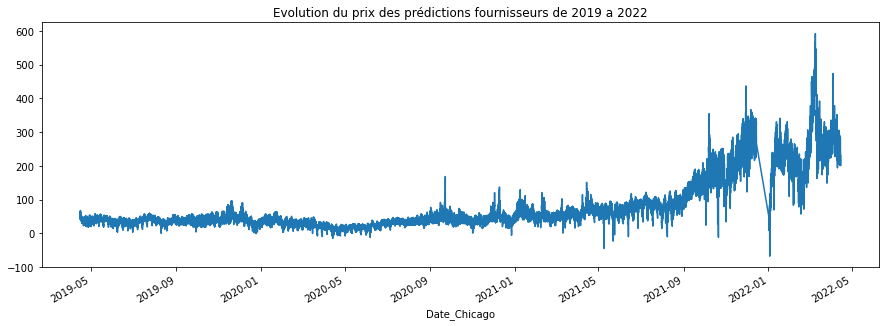

In [39]:
df_date2 = df_v

# Convertir la colonne Date en datetime
df_date2['Date_Chicago'] = pd.to_datetime(df_date2['Date_Chicago'])

# Définir la colonne Date comme index du dataframe
df_date2.set_index('Date_Chicago', inplace=True)

# Définir la taille de la figure
plt.figure(figsize=(15, 5))

# Tracer les données en utilisant la méthode plot() de pandas
df_date2['price_prediction_J1'].plot()

# Ajouter un titre au graphique
plt.title('Evolution du prix des prédictions fournisseurs de 2019 a 2022')

# Afficher le graphique
plt.show()

In [45]:
dfb2 = dfb2.reset_index()
dfb2

,Date_Chicago,price_prediction_J1
0,2019-04-15 00:00:00,61.173
1,2019-04-15 01:00:00,63.837
2,2019-04-15 02:00:00,64.166
3,2019-04-15 03:00:00,61.356
4,2019-04-15 04:00:00,55.703
...,...,...
26488,2022-04-14 19:00:00,209.105
26489,2022-04-14 20:00:00,201.155
26490,2022-04-14 21:00:00,200.503
26491,2022-04-14 22:00:00,206.363


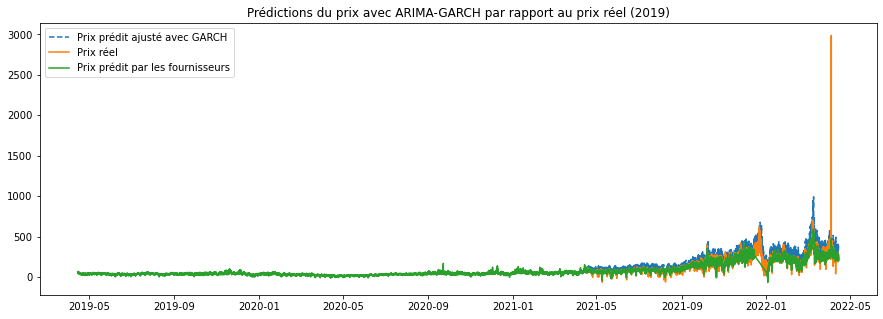

In [46]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data2['Date'], adjusted_forecasts2, label='Prix prédit ajusté avec GARCH', linestyle='--')
plt.plot(test_data2['Date'], test_data2.iloc[:, 1], label='Prix réel')
plt.plot(dfb2['Date_Chicago'], dfb2['price_prediction_J1'], label='Prix prédit par les fournisseurs')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel (2019)")
plt.show()

In [47]:
# Définir les bornes de la plage de dates souhaitée
start_date_train2 = '2019-04-15 00:00:00' 
end_date_train2 = '2021-04-15 23:00:00'

start_date_test2 = '2021-04-16 00:00:00'
end_date_test2 = '2022-04-14 23:00:00'

# Sélectionner les lignes entre les bornes de dates

test_data_v = dfb2.loc[(dfb2['Date_Chicago'] >= start_date_test2) & (dfb2['Date_Chicago'] <= end_date_test2)]

In [52]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list_f = []
for i in range(len(adjusted_forecasts2)):
    maef = mean_absolute_error([test_data2.iloc[i, 1]], [adjusted_forecasts2[i]])
    mae_list_f.append(maef)

mae_list_a = []
for i in range(len(predictions2)):
    mae3 = mean_absolute_error([test_data2.iloc[i, 1]], [predictions2[i]])
    mae_list_a.append(mae3)
    
mae_list_e = []
for i in range(len(test_data_v)):
    maee = mean_absolute_error([test_data2.iloc[i, 1]], [test_data_v.iloc[i, 1]])
    mae_list_e.append(maee)
    
# Imprimer la liste des MAE
print("MAE moyenne pour les prédictions ARIMA-GARCH par rapport aux données réels (ENTSOE) :", statistics.mean(mae_list_f))
print("MAE moyenne pour les prédictions ARIMAX par rapport aux données réels (ENTSOE) :", statistics.mean(mae_list_a))
print("MAE moyenne pour les prédictions fournisseurs par rapport aux données réels (ENTSOE) :", statistics.mean(mae_list_e))

MAE moyenne pour les prédictions ARIMA-GARCH par rapport aux données réels (ENTSOE) : 76.8086441522601
MAE moyenne pour les prédictions ARIMAX par rapport aux données réels (ENTSOE) : 26.264020802363785
MAE moyenne pour les prédictions fournisseurs par rapport aux données réels (ENTSOE) : 53.97541666666667


In [58]:
stamp = dfb2.loc[(dfb2['Date_Chicago'] >= '2021-03-05 00:00:00') & (dfb2['Date_Chicago'] <= '2021-05-05 00:00:00')]
entsoe_s = dfb.loc[(dfb['Date'] >= '2021-03-05 00:00:00') & (dfb['Date'] <= '2021-05-05 00:00:00')]

mae_e = []
for i in range(len(stamp)):
    mae = mean_absolute_error([entsoe_s.iloc[i, 1]], [stamp.iloc[i, 1]])
    mae_e.append(mae)
    
print(statistics.mean(mae_e))

16.82753893442623


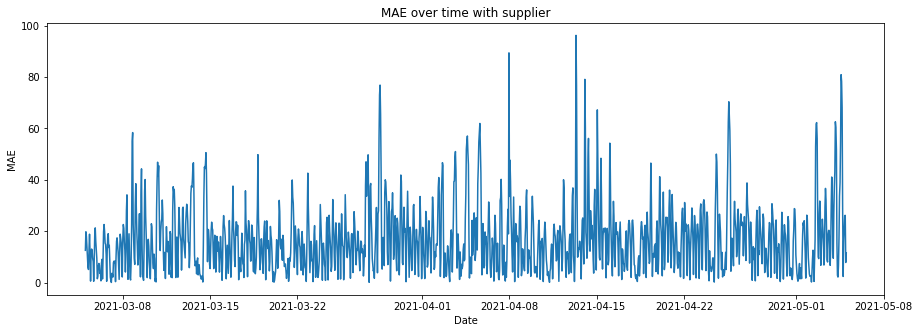

In [57]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(stamp['Date_Chicago'], mae_e)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('MAE over time with supplier')
plt.show()

In [ ]:
stop

# -----------------------------------------------------------

In [ ]:
dfb2 = dfb2.reset_index()

In [ ]:
dfb2.columns

In [ ]:
# Définir les bornes de la plage de dates souhaitée
start_date_train2 = '2019-04-15 00:00:00' 
end_date_train2 = '2021-04-15 23:00:00'

start_date_test2 = '2021-04-16 00:00:00'
end_date_test2 = '2022-04-14 23:00:00'

# Sélectionner les lignes entre les bornes de dates

test_data_v = dfb2.loc[(dfb2['Date_Chicago'] >= start_date_test2) & (dfb2['Date_Chicago'] <= end_date_test2)]

In [ ]:
test_data_v

In [ ]:
# Set the length of the training set
train_len4 = len(train_data_v)
#print(train_len)

# Create an empty array to store the predictions
predictions_v = []

# Iterate over each point in the test set
for i in range(0, len(test_data_v), 24):
    # Select the data for training the model
    if i == 0:
        train_data_subset3 = train_data_v.iloc[:train_len4, :]
    else:
        train_data_subset3 = pd.concat([train_data_v.iloc[i:, :], test_data_v.iloc[:i, :]], axis=0)
    #print("train data2 :", train_data_subset2)
        
    # Fit the ARIMA model to the training data
    model3 = ARIMA(train_data_subset3.iloc[:, 1], order=(1,1,1))
    result3 = model3.fit()
    
    # Make one-day-ahead forecasts
    forecast3 = result3.forecast(steps=24)
    print("prédictions_v :", forecast3)
    
    # Store the forecasts in the predictions array
    predictions_v.extend(forecast3)

In [ ]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
plt.plot(test_data_v['Date_Chicago'], test_data_v.iloc[:, 1], label='Prix réel')
plt.plot(test_data_v['Date_Chicago'], predictions_v, label='Prix prédit')
plt.legend()
plt.title('Prédictions du prix avec ARIMA par rapport au prix réel (données fournisseurs)')
plt.show()

In [ ]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list4 = []
for i in range(len(predictions_v)):
    mae4 = mean_absolute_error([test_data_v.iloc[i, 1]], [predictions_v[i]])
    mae_list4.append(mae4)
    
# Imprimer la liste des MAE
#print("Liste des MAE :", mae_list)


In [ ]:
# Plot the MAE over time
# Définir la taille de la figure
plt.figure(figsize=(15, 5))
plt.plot(test_data_v['Date_Chicago'], mae_list4)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.title('MAE over time with ARIMA (suppliers data)')
plt.show()

In [ ]:
# Create an empty array to store the residuals
residuals3 = []


# Iterate over each point in the test set
for i in range(len(predictions_v)):
    # Calculate the residuals
    residuals3.append(test_data_v.iloc[i, 1] - predictions_v[i])

# Fit a GARCH model to the residuals with the ARIMA forecasts as exogenous variables
am3 = arch_model(residuals3, x=predictions_v, vol='GARCH', p=1, q=1)
res3 = am3.fit()

# Make one-day-ahead forecasts using the GARCH model
garch_forecasts3 = []
for i in range(0, len(test_data_v), 24):
    forecast3 = res3.forecast(horizon=24)
    garch_forecasts3.extend(forecast3.variance.values[-1, :])

print("GARCH forecasts3 :", garch_forecasts3)

In [ ]:
observations3 = np.array(garch_forecasts3)
# Créer le filtre de Kalman
kf3 = KalmanFilter(transition_matrices=[1], observation_matrices=[1], initial_state_mean=observations3[0], initial_state_covariance=1, observation_covariance=1, transition_covariance=0.01)
# Appliquer le filtre de Kalman aux prédictions de volatilité
filtered_state_means3, filtered_state_covariances3 = kf3.filter(observations3)
# Récupérer les prédictions de volatilité filtrées
filtered_volatility_predictions3 = filtered_state_means3.flatten()

print(filtered_volatility_predictions3)

In [ ]:
# Adjust the ARIMA forecasts for volatility using the GARCH forecasts
adjusted_forecasts3 = []
for i in range(len(filtered_volatility_predictions3)):
    adjusted_forecasts3.append(predictions_v[i] * np.sqrt(filtered_volatility_predictions3[i]) * 0.02) #to adjust the scaling factor, decrease of the scaling factor by a factor of 0.05

In [ ]:
# Plot des prévisions des prix de l'électricité pour chaque période de test
plt.figure(figsize=(15, 5))
#plt.plot(test_data['Date'], test_data.iloc[:, 1], label='Prix réel')
#plt.plot(test_data['Date'], predictions, label='Prix prédit avec ARIMAX')
plt.plot(test_data_v['Date_Chicago'], test_data_v.iloc[:, 1], label='Prix réel')
plt.plot(test_data_v['Date_Chicago'], adjusted_forecasts3, label='Prix prédit ajusté avec GARCH')
plt.legend()
plt.title("Prédictions du prix avec ARIMA-GARCH par rapport au prix réel (données fournisseurs)")
plt.show()

In [ ]:
# Calculer la MAE pour chaque paire de prévision et d'étiquette véritable, et stocker les résultats dans une liste
mae_list_f = []
for i in range(len(adjusted_forecasts3)):
    maef = mean_absolute_error([test_data_v.iloc[i, 1]], [adjusted_forecasts3[i]])
    mae_list_f.append(maef)
    
mae_list_e = []
for i in range(len(adjusted_forecasts2)):
    maee = mean_absolute_error([test_data2.iloc[i, 1]], [adjusted_forecasts2[i]])
    mae_list_e.append(maee)
    
# Imprimer la liste des MAE
print("MAE moyenne pour ARIMA-GARCH (ENTSOE) :", statistics.mean(mae_list_e))
print("MAE moyenne pour ARIMA-GARCH (fournisseurs) :", statistics.mean(mae_list_f))
